# Environmental Footprint vs Human Development (1990–2023): Who Pays the Highest Price?

**Author:** Francesco Petriaggi  
**Version:** 1.0 – May 2025  
**Notebook & Code License:** MIT  
**Data Source:** World Bank – World Development Indicators (CC BY 4.0)


## Table of Contents

1. [Introduction](#introduction)  
   1.1 [Objectives](#objectives)  
   1.2 [Dataset description](#dataset-description)  
   1.3 [Key variables](#key-variables)

2. [Environment setup](#environment-setup)

3. [Data loading](#data-loading)

4. [Preprocessing](#preprocessing)  
   4.1 [2023 snapshot](#2023-snapshot)  
   4.2 [Derived variables](#derived-variables)

5. [Descriptive analysis](#descriptive-analysis)  
   5.1 [Statistics and histogram](#statistics-and-histogram)  
   5.2 [Top and bottom 10](#top-and-bottom-10)  
   5.3 [Correlations](#correlations)  
   5.4 [Drivers in the Top 10](#drivers-in-the-top-10)  
   5.5 [IQR outliers](#iqr-outliers)

6. [Group analysis](#group-analysis)  
   6.1 [By region](#by-region)  
   6.2 [By HDI category](#by-hdi-category)

7. [Geographic maps](#geographic-maps)  
   7.1 [gap_pct map](#gap_pct-map)  
   7.2 [CO₂ per capita map](#co₂-per-capita-map)  
   7.3 [Material footprint map](#material-footprint-map)

8. [Temporal analysis](#temporal-analysis)  
   8.1 [Δ gap_pct 1990–2023](#Δ-gap_pct-1990–2023)  
   8.2 [Regional trend 1990–2023](#regional-trend-1990–2023)

9. [2023 quadrant segmentation](#2023-quadrant-segmentation)

10. [Conclusions and Recommendations](#conclusions-and-recommendations)  
    10.1 [Key takeaways](#key-takeaways)  
    10.2 [Policy actions](#policy-actions)


## 1. Introduction

### 1.1 Objectives  

> **Guiding question**  
> *To what extent and with what intensity do environmental pressures—per-capita CO₂ emissions and per-capita Material Footprint—curtail human development (HDI) across countries?*

To answer this, we will:

- **Compute the HDI loss** attributable to planetary pressures, both in absolute terms (`gap`) and as a percentage (`gap_pct`).  
- **Assess the relative importance** of CO₂ vs. Material Footprint using correlation analysis and z-scores.  
- **Segment countries** into four categories (quadrants) based on thresholds for `gap_pct` and `mf_pc`, highlighting those combining high environmental pressure with high HDI loss.  
- **Compare results** by *region* and by *human development category* (UNDP classes).  
- **Analyze historical dynamics** from 1990 to 2023 to identify countries that have improved or worsened their “environmental efficiency.”

### 1.2 Dataset description  

| Attribute            | Detail                                                                                             |
|----------------------|----------------------------------------------------------------------------------------------------|
| **Source**           | World Bank – *[World Development Indicators](https://datacatalog.worldbank.org/search/dataset/0037712/World-Development-Indicators)* |
| **Format**           | CSV                                                                                                |
| **Dimensions**       | 206 rows × 1,112 columns (193 countries + 13 regional aggregates; series 1990–2023)                |
| **Time coverage**    | 1990–2023 (34 years)                                                                               |
| **Unit of analysis** | Country (or aggregate) by year                                                                     |
| **License**          | Creative Commons Attribution 4.0 (CC BY 4.0)                                                       |

### 1.3 Key variables (2023 snapshot)

| Column     | Description                                             | Scale  |
|------------|---------------------------------------------------------|--------|
| `hdi`      | Human Development Index                                 | 0–1    |
| `phdi`     | HDI adjusted for planetary pressures                    | 0–1    |
| `co2_pc`   | CO₂ emissions per capita                                | t/year |
| `mf_pc`    | Material Footprint per capita                           | t/year |

> **Technical note** – From the time-series file we extract the 2023 columns and compute:  
> `gap      = hdi - phdi` (absolute HDI loss)  
> `gap_pct  = 100 × gap / hdi` (percentage HDI loss)


## 2. Environment setup

In this section we initialize everything needed to run the notebook in a reproducible and tidy way.

* **Unified imports**  
  - Data manipulation: `pandas`, `numpy`  
  - Static visualization: `matplotlib.pyplot`, `seaborn`  
  - Interactive visualization: `plotly.express`, `plotly.graph_objects`  
  - Preprocessing: `sklearn.preprocessing.StandardScaler`  
  - System utilities: `os`, `random`, `warnings`

* **Global seed**  
  `np.random.seed(42)` and `random.seed(42)` for reproducible results.

* **Output cleaning**  
  `warnings.filterwarnings('ignore')` to suppress non-critical warnings.


In [13]:
import os
import random
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

from sklearn.preprocessing import StandardScaler

# Set seed for reproducibility
np.random.seed(42)
random.seed(42)


## 3. Data loading

In this section we import the CSV file into the `df` DataFrame and perform essential checks to ensure everything is in order.

**Steps**

1. **Read file**  
   The path is read from the `DATA_PATH` environment variable; if undefined, we use the local file `HDR25_Composite_indices_complete_time_series.csv`.  
2. **Quick checks**  
   * `df.shape` → confirm we have 206 rows × 1,112 columns.  
   * `df.head()`  → inspect the first rows to verify headers and format.  
   * `df.info()`  → summarize data types and spot any null values.  


In [14]:
# 3. Data loading
DATA_PATH = os.getenv('DATA_PATH', 'HDR25_Composite_indices_complete_time_series.csv')

df = pd.read_csv(DATA_PATH, encoding='latin1', low_memory=False)

# Essential checks
print(f"Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")  # expected: 206 × 1112
pd.set_option('display.max_columns', 25)  # show more columns in head()
display(df.head())
df.info()
print("Total null values:", df.isna().sum().sum())


Dataset loaded: 206 rows × 1112 columns


,iso3,country,hdicode,region,hdi_rank_2023,hdi_1990,hdi_1991,hdi_1992,hdi_1993,hdi_1994,hdi_1995,hdi_1996,...,pop_total_2012,pop_total_2013,pop_total_2014,pop_total_2015,pop_total_2016,pop_total_2017,pop_total_2018,pop_total_2019,pop_total_2020,pop_total_2021,pop_total_2022,pop_total_2023
0,AFG,Afghanistan,Low,SA,181.0,0.285,0.291,0.301,0.311,0.305,0.329,0.334,...,30.560034,31.622704,32.792523,33.831764,34.700612,35.688935,36.743039,37.856121,39.068979,40.000412,40.578842,41.454761
1,ALB,Albania,Very High,ECA,71.0,0.654,0.638,0.622,0.624,0.629,0.638,0.647,...,2.910004,2.907573,2.903749,2.898632,2.897867,2.898242,2.894231,2.885009,2.871954,2.849636,2.827608,2.811655
2,DZA,Algeria,High,AS,96.0,0.595,0.596,0.601,0.603,0.603,0.608,0.615,...,37.646166,38.414172,39.205030,40.019529,40.850721,41.689299,42.505035,43.294546,44.042091,44.761099,45.477390,46.164219
3,AND,Andorra,Very High,NaN,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.076834,0.075193,0.073737,0.072174,0.072181,0.073762,0.075162,0.076473,0.077380,0.078364,0.079705,0.080856
4,AGO,Angola,Medium,SSA,148.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,25.177394,26.165620,27.160770,28.157798,29.183070,30.234839,31.297155,32.375633,33.451132,34.532429,35.635029,36.749906


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Columns: 1112 entries, iso3 to pop_total_2023
dtypes: float64(1108), object(4)
memory usage: 1.7+ MB
Total null values: 28310


## 4. Preprocessing

### 4.1 Extracting the 2023 Snapshot  

**Goal:** isolate in a lightweight DataFrame (⟨Countries×6 columns⟩) all 2023 variables of interest, ready for descriptive analysis.

**Steps**

1. **Select 2023 columns**  
   - Keep descriptors `country`, `iso3`.  
   - From columns ending in `_2023`, retain:  
     `hdi_2023`, `phdi_2023`, `co2_prod_2023`, `mf_2023`.  
     > *If your CSV uses a different name (e.g. `co2_pc_2023`), adjust the list accordingly.*

2. **Clean missing data**  
   - `dropna()` removes any rows with missing values in the selected 2023 fields.  
   - You should end up with ~170 countries/aggregates with complete records.

3. **Rename columns** for readability:  
   `hdi`, `phdi`, `co2_pc`, `mf_pc`.

4. **Final checks**  
   - `snap23.shape` → expect ~170 rows × 6 columns.  
   - `snap23.head()` for a visual inspection.

*(The historical 1990–2022 columns remain in the main `df` for the later temporal analyses.)*


In [15]:
# 4.1 2023 snapshot
# 1) Columns to keep (adjust if your CSV uses different names)
keep_cols = [
    'country', 'iso3',
    'hdi_2023', 'phdi_2023',
    'co2_prod_2023',   # ← change here if needed (e.g. 'co2_pc_2023')
    'mf_2023'
]

# 2) Extract and drop rows with any NA in the selected fields
snap23 = df[keep_cols].copy().dropna()

# 3) Rename columns for clarity
snap23 = snap23.rename(columns={
    'hdi_2023':      'hdi',
    'phdi_2023':     'phdi',
    'co2_prod_2023': 'co2_pc',
    'mf_2023':       'mf_pc'
})

# 4) Verify the result
print("2023 snapshot shape:", snap23.shape)   # expected ~170 × 6
display(snap23.head())


2023 snapshot shape: (167, 6)


,country,iso3,hdi,phdi,co2_pc,mf_pc
0,Afghanistan,AFG,0.496,0.492,0.260896,1.2455
1,Albania,ALB,0.810,0.755,1.816209,10.0369
2,Algeria,DZA,0.763,0.706,3.905866,8.8042
4,Angola,AGO,0.616,0.604,0.566470,2.9376
6,Argentina,ARG,0.865,0.763,4.277679,16.3294


### 4.2 Derived variables  

To compare human development and environmental pressures, we construct two new metrics:

| Variable   | Formula               | Meaning                                                      |
|------------|-----------------------|--------------------------------------------------------------|
| `gap`      | `hdi − phdi`          | absolute HDI loss due to planetary pressures                |
| `gap_pct`  | `100 × gap / hdi`     | loss expressed as a **percentage** of the original HDI       |

**Operational steps**

1. Compute `gap` and `gap_pct` directly on `snap23`.  
2. Display the first 5 rows for a quick sanity check.  
3. Derive **minimum, maximum, and mean** of `gap_pct` to gauge dispersion across countries.

*(Note: a `gap_pct` value of 15 means that, accounting for planetary pressures, the effective HDI is 15% lower than its “theoretical” value.)*


In [16]:
# 1) Absolute and percentage HDI loss
snap23['gap']     = snap23['hdi'] - snap23['phdi']
snap23['gap_pct'] = snap23['gap'] / snap23['hdi'] * 100

# 2) Preview first five rows
display(snap23[['country', 'hdi', 'phdi', 'gap', 'gap_pct']].head())

# 3) Summary statistics for gap_pct
min_gap  = snap23['gap_pct'].min()
max_gap  = snap23['gap_pct'].max()
mean_gap = snap23['gap_pct'].mean()

print(f"Gap % – min: {min_gap:.2f}, max: {max_gap:.2f}, mean: {mean_gap:.2f}")


,country,hdi,phdi,gap,gap_pct
0,Afghanistan,0.496,0.492,0.004,0.806452
1,Albania,0.810,0.755,0.055,6.790123
2,Algeria,0.763,0.706,0.057,7.470511
4,Angola,0.616,0.604,0.012,1.948052
6,Argentina,0.865,0.763,0.102,11.791908


Gap % – min: 0.81, max: 68.85, mean: 10.48


## 5. Exploratory data analysis (EDA)

### 5.1 Descriptive statistics and histogram of `gap_pct`

**Goal**  
Quantify and visualize the distribution of percentage HDI loss (`gap_pct`) across countries in the 2023 snapshot.

| Step | Action                                      | Expected insight                                                                                     |
|------|---------------------------------------------|------------------------------------------------------------------------------------------------------|
| 1    | `snap23['gap_pct'].describe()`             | Mean, standard deviation, quartiles: indicate whether most countries lose little or substantial HDI. |
| 2    | Histogram + KDE curve                       | Reveal distribution shape, skewness, and potential country clusters.                                  |
| 3    | Vertical lines at mean & median             | Highlight distribution imbalance (mean ≠ median).                                                     |

> A `gap_pct` of 12% means that, accounting for planetary pressures, the effective HDI is 12% lower than its “theoretical” value.


count    167.00
mean      10.48
std       10.01
min        0.81
25%        2.89
50%        7.48
75%       14.60
max       68.85
Name: gap_pct, dtype: float64


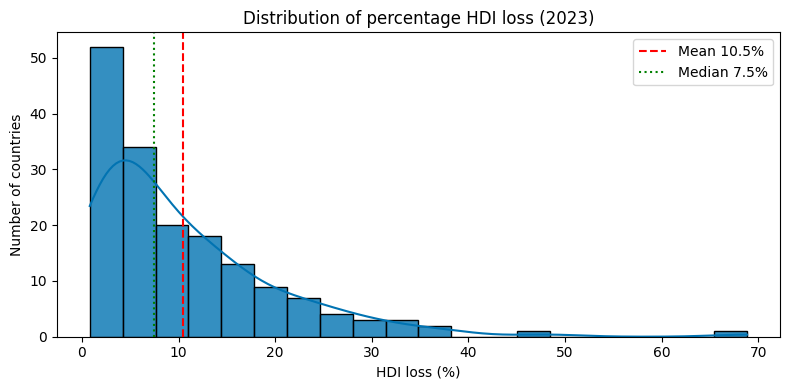

In [17]:
# 1) Descriptive statistics
desc = snap23['gap_pct'].describe().round(2)
print(desc)

# 2) Histogram with KDE
plt.figure(figsize=(8,4))
sns.histplot(
    snap23['gap_pct'],
    bins=20,
    kde=True,
    color=sns.color_palette("colorblind")[0],
    alpha=0.8
)
plt.xlabel('HDI loss (%)')
plt.ylabel('Number of countries')
plt.title('Distribution of percentage HDI loss (2023)')

# 3) Lines at mean and median
mean_val = snap23['gap_pct'].mean()
median_val = snap23['gap_pct'].median()
plt.axvline(mean_val,   color='red',   linestyle='--', label=f'Mean {mean_val:.1f}%')
plt.axvline(median_val, color='green', linestyle=':',  label=f'Median {median_val:.1f}%')
plt.legend()
plt.tight_layout()
plt.show()

### 5.2 Top-10 and Bottom-10 Countries by `gap_pct`

**Goal**  
Highlight the extremes of the distribution: countries suffering the highest percentage HDI loss (Top-10) and those with the lowest loss (Bottom-10).

| Step | Action                                                      |
|------|-------------------------------------------------------------|
| 1    | `nlargest(10, 'gap_pct')` → most penalized countries.       |
| 2    | `nsmallest(10, 'gap_pct')` → most resilient countries.       |
| 3    | Two horizontal bar plots on the same X scale, using color-blind-friendly palettes and value labels on the bars. |

> The immediate visual comparison helps isolate outliers for deeper analysis.


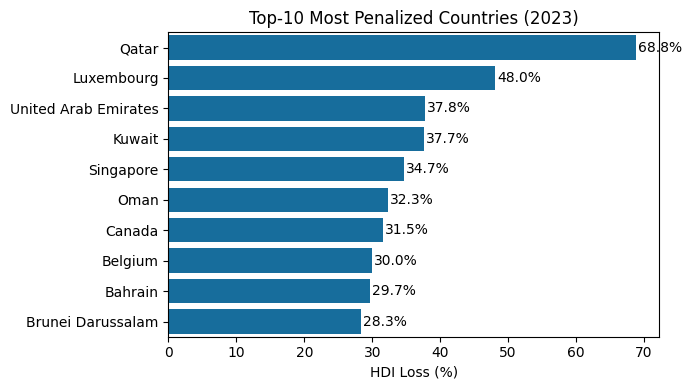

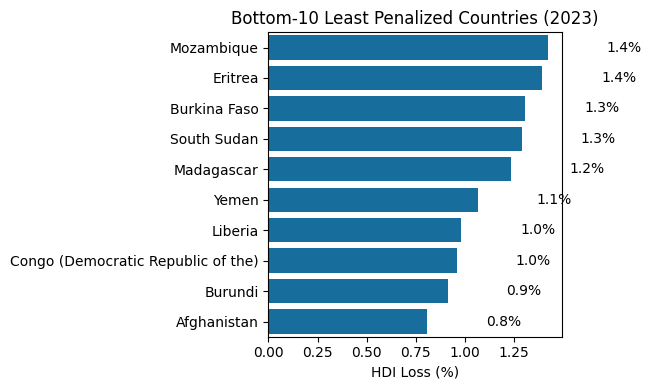

In [18]:
# 5.2 Top-10 / Bottom-10
palette = sns.color_palette("colorblind")[0]   # accessible blue

def add_labels(ax):
    """Print the numeric value at the end of each bar."""
    for p in ax.patches:
        ax.text(
            p.get_width() + 0.3,
            p.get_y() + p.get_height() / 2,
            f"{p.get_width():.1f}%",
            va='center'
        )

# Top-10 most penalized countries
top10 = snap23.nlargest(10, 'gap_pct')[['country', 'gap_pct']]
fig, ax = plt.subplots(figsize=(7,4))
sns.barplot(
    data=top10,
    x='gap_pct',
    y='country',
    ax=ax,
    color=palette
)
ax.set_xlabel('HDI Loss (%)')
ax.set_ylabel('')
ax.set_title('Top-10 Most Penalized Countries (2023)')
add_labels(ax)
plt.tight_layout()
plt.show()

# Bottom-10 least penalized countries
bottom10 = (
    snap23
    .nsmallest(10, 'gap_pct')[['country', 'gap_pct']]
    .sort_values('gap_pct', ascending=False)
)
fig, ax = plt.subplots(figsize=(7,4))
sns.barplot(
    data=bottom10,
    x='gap_pct',
    y='country',
    ax=ax,
    color=palette
)
ax.set_xlabel('HDI Loss (%)')
ax.set_ylabel('')
ax.set_title('Bottom-10 Least Penalized Countries (2023)')
add_labels(ax)
plt.tight_layout()
plt.show()

### 5.3 Correlations between `gap_pct`, `co2_pc`, and `mf_pc`

**Goal**  
Understand which of the two environmental pressures (per-capita CO₂ or Material Footprint) is more strongly associated with percentage HDI loss.

| Step | Action                       | Expected insight                                                                 |
|------|------------------------------|----------------------------------------------------------------------------------|
| 1    | Calculate Pearson            | Strength of the **linear** relationship between variables.                        |
| 2    | Calculate Spearman           | Strength of the **monotonic** relationship (robust to outliers and non-linearities). |
| 3    | Pearson heatmap              | Immediate visual comparison of coefficients (scale −1 … +1).                     |

> If the two coefficients are similar in absolute value, the relationship is both linear and monotonic; if Spearman ≫ Pearson, the trend may be curvilinear.


Pearson correlations:


,gap_pct,co2_pc,mf_pc
gap_pct,1.00,0.87,0.97
co2_pc,0.87,1.00,0.71
mf_pc,0.97,0.71,1.00


Spearman correlations:


,gap_pct,co2_pc,mf_pc
gap_pct,1.00,0.92,0.98
co2_pc,0.92,1.00,0.84
mf_pc,0.98,0.84,1.00


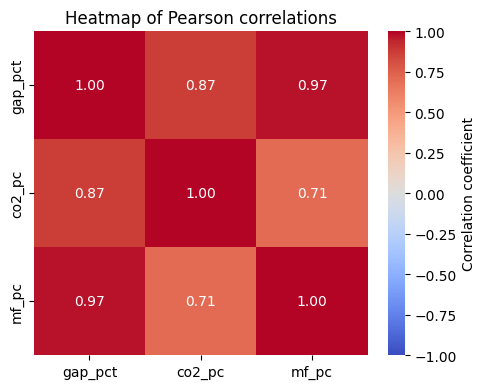

In [19]:
# 5.3 Correlations
vars_to_corr = ['gap_pct', 'co2_pc', 'mf_pc']

# 1) Pearson and Spearman correlations
pearson  = snap23[vars_to_corr].corr(method='pearson').round(2)
spearman = snap23[vars_to_corr].corr(method='spearman').round(2)

print("Pearson correlations:")
display(pearson)
print("Spearman correlations:")
display(spearman)

# 2) Pearson correlation heatmap
plt.figure(figsize=(5,4))
sns.heatmap(
    pearson,
    annot=True, fmt=".2f",
    cmap='coolwarm', vmin=-1, vmax=1,
    cbar_kws={'label':'Correlation coefficient'}
)
plt.title('Heatmap of Pearson correlations')
plt.tight_layout()
plt.show()

#### Commentary on correlation results

* **Material Footprint is the strongest driver** – the correlation between `gap_pct` and `mf_pc` is nearly perfect (*r* = 0.97 Pearson; ρ = 0.98 Spearman), indicating that per-capita material footprint explains most of the HDI loss.

* **CO₂ per capita also matters, but to a lesser extent** – its relationship with `gap_pct` remains high (*r* = 0.87; ρ = 0.92), yet lower than that of Material Footprint.  
  > *Interpretation:* MF captures resource consumption across the entire supply chain, thus reflecting broader impacts than CO₂ emissions alone.

* **Environmental pressures are correlated with each other** – `co2_pc` and `mf_pc` share a moderately high positive correlation (*r* = 0.71; ρ = 0.84); this is expected since energy-intensive materials production generates CO₂.  
  Consequently, multivariate analyses will need to account for **multicollinearity**.

* **Spearman > Pearson** by a few points indicates that the relationship remains monotonic even where it may not be strictly linear (possible “elbow” effect for countries with very high footprints).


### 5.4 Comparison of Drivers in the Top-10 Countries

**Goal**  
Determine whether, among the most penalized countries, per-capita Material Footprint or per-capita CO₂ emissions weighs more compared to the global average.

| Step | Action                                                                 | Interpretation                                                  |
|------|------------------------------------------------------------------------|-----------------------------------------------------------------|
| 1    | Compute global **z-scores** for `co2_pc` and `mf_pc` on the full 2023 snapshot (µ = 0, σ = 1). | Values **> 0** indicate above-global-average levels; **< 0** below. |
| 2    | Select the 10 countries with the highest `gap_pct`.                    | These represent the worst outliers in terms of HDI loss.        |
| 3    | Create a horizontal grouped barplot (`z_co2` vs. `z_mf`), ordered by `gap_pct`. | If the green bar (`z_mf`) greatly exceeds the orange bar (`z_co2`), Material Footprint is the dominant driver, and vice-versa. |

> **Note** – We use z-scores to make the two variables comparable despite different units (tons of CO₂ vs. tons of materials).


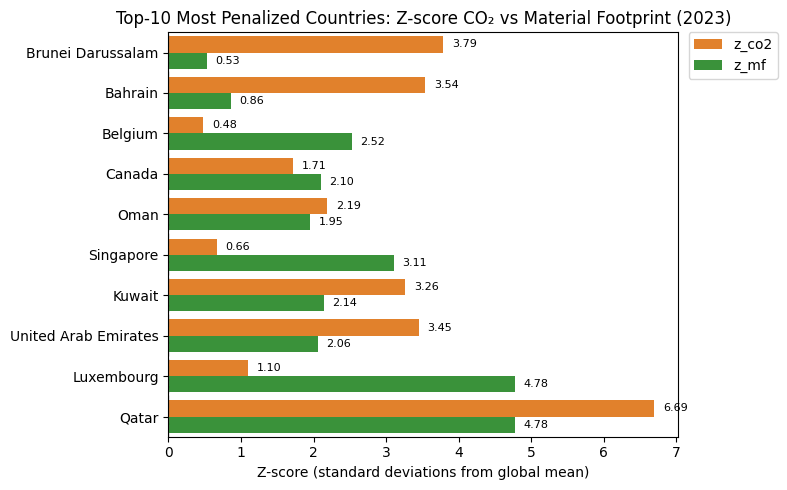

In [20]:
# 5.4 Z-score CO₂ vs Material Footprint for Top-10 Countries

# 1) Compute global z-scores
snap23['z_co2'] = (snap23['co2_pc'] - snap23['co2_pc'].mean()) / snap23['co2_pc'].std()
snap23['z_mf']  = (snap23['mf_pc']  - snap23['mf_pc'].mean())  / snap23['mf_pc'].std()

# 2) Identify Top-10 by gap_pct (sorted ascending for horizontal plot)
top10 = (
    snap23
    .nlargest(10, 'gap_pct')
    .sort_values('gap_pct', ascending=True)
)

# 3) Reshape to long format
plot_df = top10.melt(
    id_vars='country',
    value_vars=['z_co2', 'z_mf'],
    var_name='Indicator',
    value_name='z_score'
)

# 4) Plot grouped horizontal barplot
plt.figure(figsize=(8,5))
palette = {'z_co2': '#FF7F0E', 'z_mf': '#2CA02C'}
ax = sns.barplot(
    data=plot_df,
    x='z_score',
    y='country',
    hue='Indicator',
    palette=palette
)

# Zero line
ax.axvline(0, color='grey', lw=1, ls='--')

# Numeric labels for |z_score| > 0.3
for p in ax.patches:
    width = p.get_width()
    if abs(width) < 0.3:
        continue
    x_txt = width + 0.12 if width > 0 else width - 0.12
    ha    = 'left' if width > 0 else 'right'
    ax.text(
        x_txt,
        p.get_y() + p.get_height()/2,
        f'{width:.2f}',
        va='center',
        ha=ha,
        fontsize=8
    )

ax.set_xlabel('Z-score (standard deviations from global mean)')
ax.set_ylabel('')
ax.set_title('Top-10 Most Penalized Countries: Z-score CO₂ vs Material Footprint (2023)')

# Legend outside plot
ax.legend(
    title='',
    loc='upper left',
    bbox_to_anchor=(1.02, 1.0),
    borderaxespad=0
)

plt.tight_layout()
plt.show()


#### Reading the chart  

* **Gulf countries (Qatar, UAE, Kuwait, Oman, Bahrain, Brunei)**  
  exhibit much higher z-scores for **CO₂ per capita**: here, HDI loss is driven primarily by emissions from fossil fuel production and export.

* **Luxembourg, Singapore, Canada, Belgium**  
  instead show higher z-scores for **Material Footprint**: development penalties stem more from resource-intensive consumption (imports of raw materials, high-material-input supply chains) than from CO₂ emissions alone.

**Operational interpretation**

- In energy-exporting countries, the priority driver to mitigate is CO₂: targeted decarbonization policies and energy diversification can directly reduce HDI loss.
- In high-consumption countries, it is more effective to improve **material-use efficiency** (circular economy initiatives, primary resource taxation) to contain the overall ecological footprint.


### 5.5 Outlier detection using the IQR method

**Goal**  
Identify countries that fall into the extreme tails of the distribution for any of the three key variables.

| Step | Action                                                                                                   |
|------|----------------------------------------------------------------------------------------------------------|
| 1    | Compute Q1, Q3, and the **IQR** (Q3 − Q1) for `gap_pct`, `co2_pc`, and `mf_pc`.                          |
| 2    | Define outliers as values **< Q1 − 1.5·IQR** or **> Q3 + 1.5·IQR**.                                        |
| 3    | Store outliers in a dictionary `outliers` → for each variable, list “low” and “high” outlier countries. |
| 4    | Display three boxplots for immediate visual confirmation.                                                |

> The IQR method is robust because it doesn’t assume normality; it uses the interquartile range to define the tails.



► gap_pct: low outliers = 0, high outliers = 6


,country,gap_pct
142,Qatar,68.848758
102,Luxembourg,48.047722
184,United Arab Emirates,37.765957
92,Kuwait,37.676056
157,Singapore,34.672304
131,Oman,32.284382



► co2_pc: low outliers = 0, high outliers = 11


,country,co2_pc
142,Qatar,42.597623
24,Brunei Darussalam,26.008786
12,Bahrain,24.588744
184,United Arab Emirates,24.102838
92,Kuwait,23.023414
152,Saudi Arabia,19.925970
131,Oman,16.904567
8,Australia,14.485056
186,United States,14.445414
31,Canada,14.164020



► mf_pc: low outliers = 0, high outliers = 5


,country,mf_pc
102,Luxembourg,74.1710
142,Qatar,74.1406
157,Singapore,53.0402
16,Belgium,45.6710
92,Kuwait,40.8308


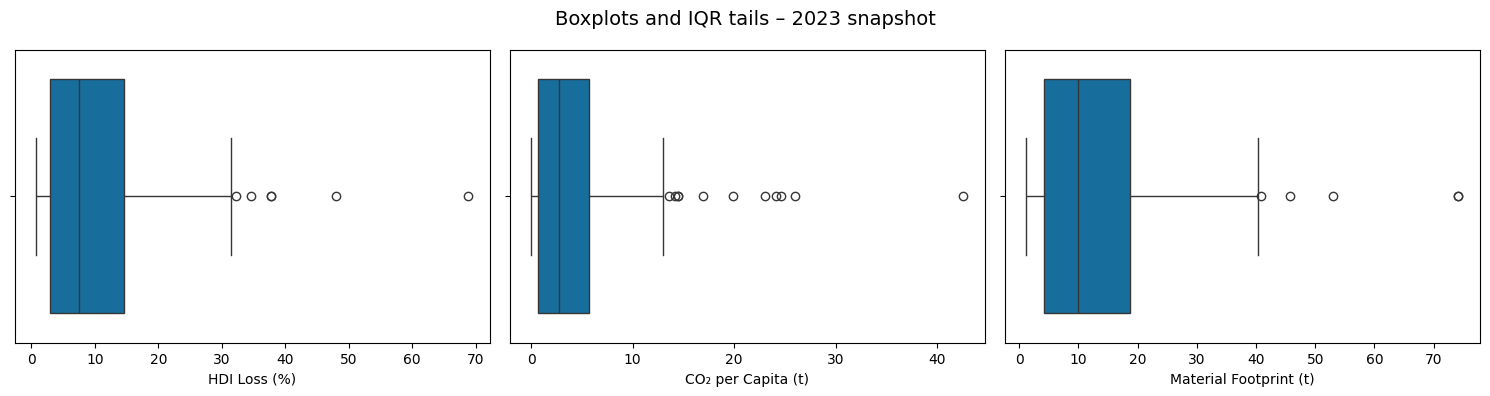

In [21]:
# 5.5 Outlier detection with the IQR method
vars_to_check = ['gap_pct', 'co2_pc', 'mf_pc']
outliers = {}

for var in vars_to_check:
    q1  = snap23[var].quantile(0.25)
    q3  = snap23[var].quantile(0.75)
    iqr = q3 - q1
    lower_lim = q1 - 1.5 * iqr
    upper_lim = q3 + 1.5 * iqr

    low_out  = snap23[snap23[var] <  lower_lim][['country', var]]
    high_out = snap23[snap23[var] >  upper_lim][['country', var]]

    outliers[var] = {'low': low_out, 'high': high_out}

    print(f"\n► {var}: low outliers = {len(low_out)}, high outliers = {len(high_out)}")

    if not low_out.empty:
        display(low_out.sort_values(var))
    if not high_out.empty:
        display(high_out.sort_values(var, ascending=False))

# 4) Boxplots for the three variables
fig, axes = plt.subplots(1, 3, figsize=(15,4))

for ax, var, title in zip(
        axes,
        ['gap_pct', 'co2_pc', 'mf_pc'],
        ['HDI Loss (%)', 'CO₂ per Capita (t)', 'Material Footprint (t)']):
    sns.boxplot(x=snap23[var], ax=ax, color=sns.color_palette("colorblind")[0])
    ax.set_xlabel(title)

fig.suptitle('Boxplots and IQR tails – 2023 snapshot', fontsize=14)
plt.tight_layout()
plt.show()


#### Commentary on outliers (IQR method)

| Variable  | # high outliers | Countries involved                                                  | Quick read                                                                                              |
|-----------|-----------------|-----------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------|
| `gap_pct` | **6**           | Qatar, Luxembourg, UAE, Kuwait, Singapore, Oman                      | Lose between 32% and 69% of HDI: same countries as in previous charts.                                  |
| `co2_pc`  | **11**          | (in addition to the above 6) Brunei Darussalam, Saudi Arabia, Australia, USA, Canada, Mongolia | Outliers driven by hydrocarbon production (Gulf), large energy-intensive economies (USA, Australia, Canada), or coal (Mongolia). |
| `mf_pc`   | **5**           | Luxembourg, Qatar, Singapore, Belgium, Kuwait                         | Small, high-income states importing large quantities of goods/materials relative to their population.  |

**Summary**

- **Qatar** is an outlier on **all three** metrics: an extreme case of human development heavily “eroded” by environmental pressures.  
- Gulf countries dominate the CO₂ and `gap_pct` outliers, confirming that oil/gas-related emissions are the primary driver of their HDI loss.  
- Luxembourg and Singapore emerge mainly for **Material Footprint**, indicating that resource-intensive consumption (imports) matters more than domestic emissions.  


## 6. Group analysis

### 6.1 Analysis by region

**Goal**  
Measure how HDI loss (`gap_pct`) and the two environmental pressures (`co2_pc`, `mf_pc`) vary across the world’s major macro-regions.

| Step | Action                                                                                 |
|------|----------------------------------------------------------------------------------------|
| 1    | Add the `region` column to `snap23` from the original dataset (`df`).                  |
| 2    | Convert region codes into full labels (`Arab States`, `Latin America & Caribbean`, …). |
| 3    | Compute mean, median, and standard deviation of `gap_pct`, `co2_pc`, and `mf_pc` for each macro-region. |
| 4    | Plot a bar chart of the **average `gap_pct`** by region, sorted from highest to lowest. |

> Comparing by region helps identify where environmental pressures most heavily penalize human development and where the average impact is more contained.


gap_pct               co2_pc                mf_pc  \
                             mean median    std   mean median    std   mean   
region_full                                                                   
Arab States                 15.06   6.10  17.94   9.15   3.13  11.88  16.42   
East Asia & Pacific         13.02   8.75  10.46   6.26   3.39   7.11  16.15   
Europe & Central Asia        8.75   7.48   4.46   4.46   3.57   3.27  10.53   
Latin America & Caribbean    7.77   6.73   4.33   2.33   2.06   1.32  11.29   
South Asia                   5.32   3.53   4.65   2.09   0.88   2.95   7.17   
Sub-Saharan Africa           2.72   2.14   1.81   0.72   0.29   1.24   4.10   

                                         
                          median    std  
region_full                              
Arab States                 8.09  18.76  
East Asia & Pacific        11.73  13.40  
Europe & Central Asia       9.99   5.07  
Latin America & Caribbean   9.46   7.04  
South Asia                  4.78   7.33  
Sub-Saharan Africa          3.47   2.57

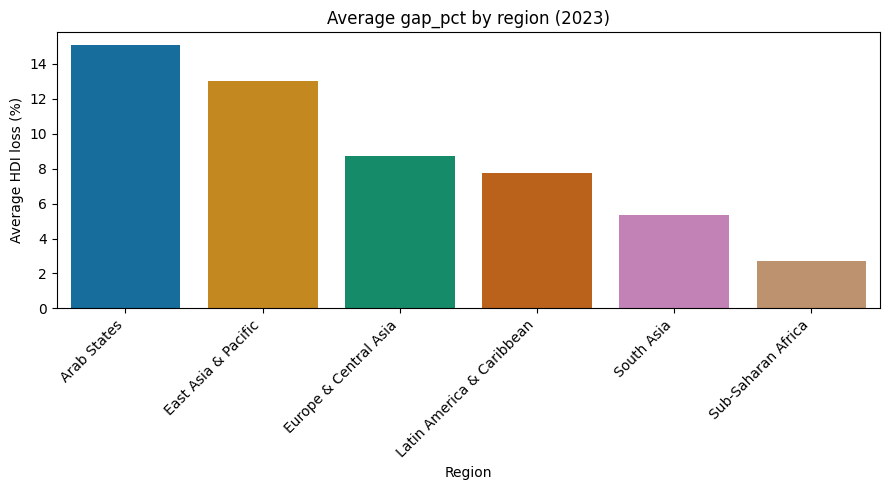

In [22]:
# 6.1 Analysis by region

# 1) Add 'region' column if not already present (safe merge)
if 'region' not in snap23.columns:
    snap23 = snap23.merge(df[['country', 'region']], on='country', how='left')

# 2) Map region codes to full names
region_map = {
    'AS':  'Arab States',
    'EAP': 'East Asia & Pacific',
    'ECA': 'Europe & Central Asia',
    'LAC': 'Latin America & Caribbean',
    'SA':  'South Asia',
    'SSA': 'Sub-Saharan Africa'
}
snap23['region_full'] = snap23['region'].map(region_map)

# 3) Descriptive statistics by region
region_stats = (
    snap23
    .groupby('region_full')[['gap_pct', 'co2_pc', 'mf_pc']]
    .agg(['mean', 'median', 'std'])
    .round(2)
)
display(region_stats)

# 4) Bar plot of average gap_pct per region (ordered)
gap_mean = region_stats[('gap_pct', 'mean')].sort_values(ascending=False)
df_plot = gap_mean.reset_index()
df_plot.columns = ['region_full', 'gap_mean']

# Generate a colorblind-friendly palette for six regions
palette_6 = dict(
    zip(
        df_plot['region_full'],
        sns.color_palette("colorblind", len(df_plot))
    )
)

plt.figure(figsize=(9,5))
sns.barplot(
    data=df_plot,
    x='region_full',
    y='gap_mean',
    hue='region_full',
    palette=palette_6,
    legend=False  # no legend since labels are on the x-axis
)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Region')
plt.ylabel('Average HDI loss (%)')
plt.title('Average gap_pct by region (2023)')
plt.tight_layout()
plt.show()


### 6.2 Analysis by Human Development Category

**Goal**  
Assess whether the impact of environmental pressures on human development (`gap_pct`) varies with HDI level.

| Step | Action                                                                                  |
|------|-----------------------------------------------------------------------------------------|
| 1    | Add the `hdicode` column (Low, Medium, High, Very High) to `snap23`.                    |
| 2    | Compute mean, median, standard deviation, and count of `gap_pct` within each category.  |
| 3    | Draw a **boxplot** of `gap_pct`, ordered from Low to Very High.                         |

> Comparing the boxplots shows both central tendency and dispersion (tails, outliers) across different HDI levels.


,mean,median,std,count
hdicode,,,,
Low,2.04,1.91,1.25,25
Medium,3.92,2.82,2.75,32
High,7.49,6.44,4.05,37
Very High,19.36,16.30,10.77,62


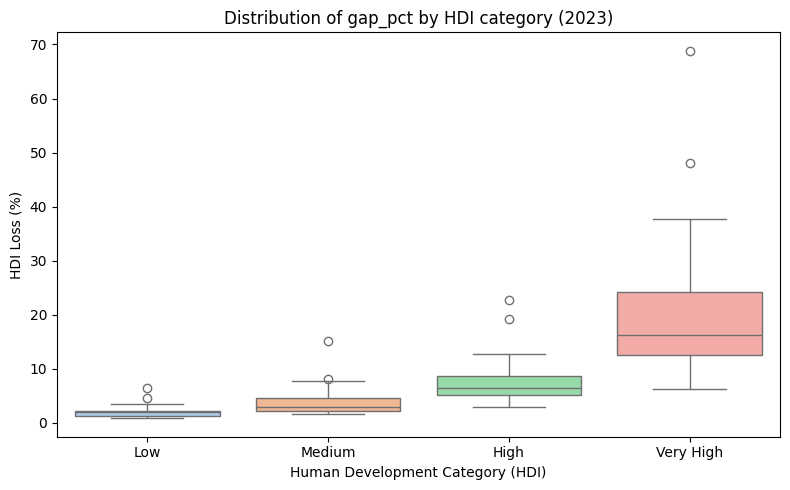

In [23]:
# 6.2 Boxplot of gap_pct by HDI category
order_hdi = ['Low', 'Medium', 'High', 'Very High']

# 1) Merge 'hdicode' if not already present
if 'hdicode' not in snap23.columns:
    snap23 = snap23.merge(
        df[['country', 'hdicode']],
        on='country', how='left'
    )

# 2) Summary statistics by HDI category
hdi_stats = (
    snap23
    .groupby('hdicode')['gap_pct']
    .agg(['mean', 'median', 'std', 'count'])
    .reindex(order_hdi)
    .round(2)
)
display(hdi_stats)

# 3) Boxplot of gap_pct for each HDI category
plt.figure(figsize=(8,5))
palette_4 = dict(zip(order_hdi, sns.color_palette("pastel", 4)))

ax = sns.boxplot(
    data=snap23,
    x='hdicode', y='gap_pct',
    order=order_hdi,
    hue='hdicode',      # avoid FutureWarning by using hue
    palette=palette_4,
    dodge=False         # one box per category
)

ax.legend_.remove()     # remove redundant legend
ax.set_xlabel('Human Development Category (HDI)')
ax.set_ylabel('HDI Loss (%)')
ax.set_title('Distribution of gap_pct by HDI category (2023)')

plt.tight_layout()
plt.show()


## 7. Geographic maps

### 7.1 Choropleth of HDI loss (`gap_pct`)

**Goal**  
Display on a global scale how percentage HDI loss varies from country to country.

| Step | Detail                                                                                              |
|------|-----------------------------------------------------------------------------------------------------|
| 1    | `locations='iso3'` → Plotly recognizes country boundaries using the ISO-3 code.                     |
| 2    | `color='gap_pct'` with the **RdYlGn_r** scale (green = low impact, red = high impact).              |
| 3    | `range_color` set to the 95th percentile to prevent a few outliers from “flattening” the color scale. |

The result is an interactive map: hovering over a country shows its name and exact `gap_pct` value.


In [24]:
# 7.1 Choropleth of gap_pct (2023)
fig = px.choropleth(
    snap23,
    locations='iso3',
    color='gap_pct',
    hover_name='country',
    color_continuous_scale='RdYlGn_r',
    range_color=(0, snap23['gap_pct'].quantile(0.95)),   # cap super-outliers
    title='Percentage HDI Loss (gap_pct) – 2023',
    labels={'gap_pct': 'HDI Loss (%)'}
)

fig.update_layout(
    margin=dict(l=0, r=0, t=50, b=0),
    coloraxis_colorbar=dict(title='HDI&nbsp;Loss&nbsp;%')
)

fig.show()


### 7.2 Choropleth of per-capita CO₂ emissions (`co2_pc`)

**Goal**  
Highlight the “mega-emitters” and, more generally, the geographical distribution of per-capita CO₂ emissions in 2023.

| Step | Detail                                                                                       |
|------|----------------------------------------------------------------------------------------------|
| 1    | `locations='iso3'` → identifies country boundaries using the ISO-3 code.                    |
| 2    | `color='co2_pc'` with **RdYlGn_r** scale (green = low emissions, red = high emissions).     |
| 3    | `range_color` limited to the 95th percentile so that a few extreme outliers don’t flatten the legend. |


In [25]:
# 7.2 Choropleth of per-capita CO₂ emissions (2023)
fig = px.choropleth(
    snap23,
    locations='iso3',
    color='co2_pc',
    hover_name='country',
    color_continuous_scale='RdYlGn_r',
    range_color=(0, snap23['co2_pc'].quantile(0.95)),   # cap at the 95th percentile
    title='Per-capita CO₂ emissions (t) – 2023',
    labels={'co2_pc': 't CO₂ per capita'}
)

fig.update_layout(
    margin=dict(l=0, r=0, t=50, b=0),
    coloraxis_colorbar=dict(title='t&nbsp;CO₂<br>per capita')
)

fig.show()


### 7.3 Choropleth of per-capita Material Footprint (`mf_pc`)

**Goal**  
Show where resource consumption (Material Footprint) is most intense in 2023.

| Step | Detail                                                                                              |
|------|-----------------------------------------------------------------------------------------------------|
| 1    | `locations='iso3'` → plot national boundaries using the ISO-3 code.                                 |
| 2    | `color='mf_pc'` with **RdYlGn_r** scale (green = low footprint, red = high footprint).             |
| 3    | `range_color` capped at the 95th percentile to prevent a few extreme values from compressing the color scale. |


In [26]:
# 7.3 Choropleth of per-capita Material Footprint (2023)
fig = px.choropleth(
    snap23,
    locations='iso3',
    color='mf_pc',
    hover_name='country',
    color_continuous_scale='RdYlGn_r',
    range_color=(0, snap23['mf_pc'].quantile(0.95)),   # cap at the 95th percentile
    title='Per-capita Material Footprint (t) – 2023',
    labels={'mf_pc': 't of resources per capita'}
)

fig.update_layout(
    margin=dict(l=0, r=0, t=50, b=0),
    coloraxis_colorbar=dict(title='t&nbsp;resources<br>per capita')
)

fig.show()


## 8. Temporal analysis

### 8.1 Countries with the greatest improvement or deterioration

**Goal**  
Compare the evolution of `gap_pct` from 1990 to 2023:

**Steps**

| Step | Action                                                                 |
|------|------------------------------------------------------------------------|
| 1    | Build a “long” DataFrame (`ts`) with columns `country`, `year`, `gap_pct`. |
| 2    | Pivot to get 1990 and 2023 as columns and compute `Δ gap_pct = gap_pct_2023 − gap_pct_1990`. |
| 3    | Select the 10 countries that have reduced HDI loss the most (improvements) and the 10 that have increased it the most (deteriorations). |
| 4    | Plot a divergent bar chart; the vertical zero line separates improvements from deteriorations. |


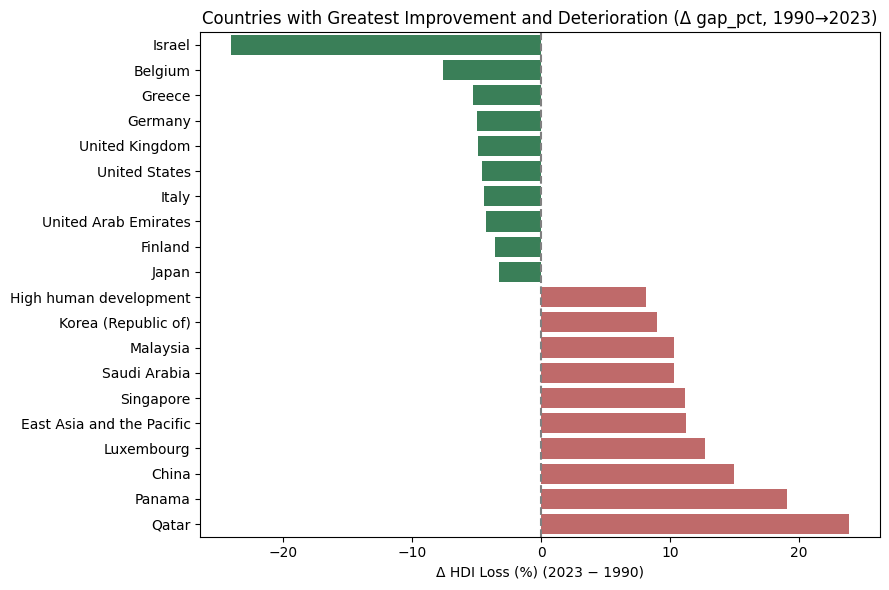

In [27]:
# 8.1 Δ gap_pct 1990 → 2023

# 1) Build the long DataFrame (country, year, gap_pct)
years = range(1990, 2024)
records = []

for y in years:
    hdi_col, phdi_col = f'hdi_{y}', f'phdi_{y}'
    if {hdi_col, phdi_col}.issubset(df.columns):
        tmp = df[['country', hdi_col, phdi_col]].dropna()
        tmp = tmp.rename(columns={hdi_col: 'hdi', phdi_col: 'phdi'})
        tmp['year']    = y
        tmp['gap_pct'] = (tmp['hdi'] - tmp['phdi']) / tmp['hdi'] * 100
        records.append(tmp[['country', 'year', 'gap_pct']])

ts = pd.concat(records, ignore_index=True)

# 2) Pivot: columns 1990 and 2023 → compute Δ
delta_df = ts.pivot(index='country', columns='year', values='gap_pct').reset_index()
delta_df['delta_gap_pct'] = delta_df[2023] - delta_df[1990]

# 3) Top-10 improvements / deteriorations
top_improved = delta_df.nsmallest(10, 'delta_gap_pct')[['country', 'delta_gap_pct']].copy()
top_worsened = delta_df.nlargest(10, 'delta_gap_pct')[['country', 'delta_gap_pct']].copy()

top_improved['type'] = 'Improvement'
top_worsened['type'] = 'Deterioration'

subset = pd.concat([top_improved, top_worsened]).sort_values('delta_gap_pct')

# 4) Divergent bar chart (no legend)
plt.figure(figsize=(9,6))
sns.barplot(
    data=subset,
    x='delta_gap_pct', y='country',
    hue='type', dodge=False,
    palette={'Improvement':'seagreen', 'Deterioration':'indianred'}
)
plt.axvline(0, color='grey', ls='--')
plt.xlabel('Δ HDI Loss (%) (2023 − 1990)')
plt.ylabel('')
plt.title('Countries with Greatest Improvement and Deterioration (Δ gap_pct, 1990→2023)')
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.show()


### 8.2 Trend of `gap_pct` (1990–2023) by macro-region

**Goal**  
Observe how the average HDI loss has changed year by year in the world’s main regions.

| Step | Action                                                                            |
|------|-----------------------------------------------------------------------------------|
| 1    | Build a “long” DataFrame (`ts`) with `country × year × gap_pct`.                  |
| 2    | Add `region_full` labels (Arab States, East Asia & Pacific, Europe & Central Asia, Latin America & Caribbean, South Asia, Sub-Saharan Africa). |
| 3    | Compute the **annual average** of `gap_pct` for each region.                      |
| 4    | Draw a multi-line plot: one line per region.                                      |

> The average is computed over all countries with available HDI and PHDI data for the given year; any missing years are automatically excluded.


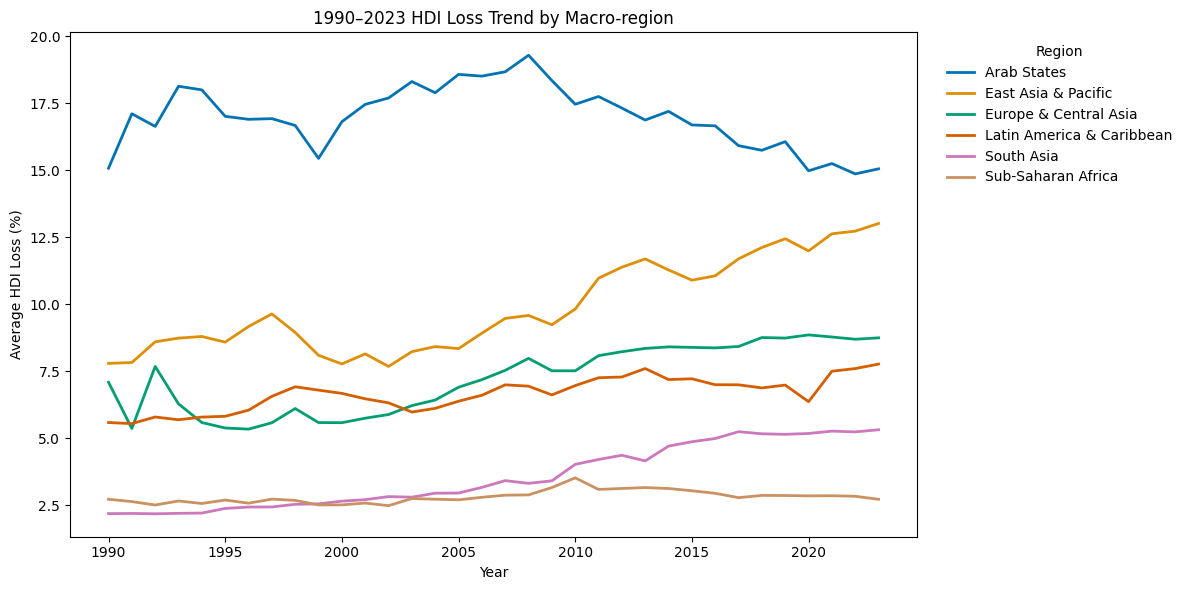

In [28]:
# 8.2 Trend of gap_pct by macro-region (1990–2023)

# 1) Build the long DataFrame (country, region, year, gap_pct)
years = range(1990, 2024)
records = []

for y in years:
    hdi_col, phdi_col = f'hdi_{y}', f'phdi_{y}'
    if {hdi_col, phdi_col}.issubset(df.columns):
        tmp = df[['country', 'region', hdi_col, phdi_col]].dropna()
        tmp = tmp.rename(columns={hdi_col: 'hdi', phdi_col: 'phdi'})
        tmp['year']    = y
        tmp['gap_pct'] = (tmp['hdi'] - tmp['phdi']) / tmp['hdi'] * 100
        records.append(tmp[['country', 'region', 'year', 'gap_pct']])

ts = pd.concat(records, ignore_index=True)

# 2) Map region codes to full labels
region_map = {
    'AS':  'Arab States',
    'EAP': 'East Asia & Pacific',
    'ECA': 'Europe & Central Asia',
    'LAC': 'Latin America & Caribbean',
    'SA':  'South Asia',
    'SSA': 'Sub-Saharan Africa'
}
ts['region_full'] = ts['region'].map(region_map)

# 3) Compute annual average gap_pct per region
trend = (
    ts
    .groupby(['region_full', 'year'])['gap_pct']
    .mean()
    .reset_index()
    .dropna(subset=['region_full'])  # exclude any unmapped regions
)

# 4) Multi-line plot
plt.figure(figsize=(12,6))
sns.lineplot(
    data=trend,
    x='year', y='gap_pct',
    hue='region_full',
    palette=sns.color_palette("colorblind", 6),
    linewidth=2
)

plt.xlabel('Year')
plt.ylabel('Average HDI Loss (%)')
plt.title('1990–2023 HDI Loss Trend by Macro-region')

# Place legend outside the plot
plt.legend(
    title='Region',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    frameon=False
)
plt.tight_layout()
plt.show()


## 9. 2023 Quadrant Segmentation

In this chart:

* **Divide** countries into four categories using two fixed thresholds:  
  – `thr_mf = 10` t per-capita Material Footprint  
  – `thr_gap = 10` % HDI loss (`gap_pct`)  
* **Color** points with an accessible palette (blue, green, orange, red).  
* **Highlight** each quadrant with a semi-transparent fill and place its name at the center.  
* **Count** countries per category and include the numbers in the title.  
* **Make** the chart interactive: hover reveals country name, footprint (t), and HDI loss (%).

> **Quick interpretation**  
> *High-High* (red) = high resource consumption and high HDI loss;  
> *Low-Low* (blue) = low on both axes;  
> the other two quadrants indicate selective criticalities (only consumption or only loss).


In [29]:
# Quadrant chart with highlighted background

# 1) Data and thresholds
thr_mf  = 10  # t per-capita Material Footprint
thr_gap = 10  # % HDI loss

# Recompute/ensure 'quad' column in snapshot
conds  = [
    (snap23.gap_pct > thr_gap) & (snap23.mf_pc > thr_mf),
    (snap23.gap_pct <= thr_gap) & (snap23.mf_pc > thr_mf),
    (snap23.gap_pct > thr_gap) & (snap23.mf_pc <= thr_mf)
]
labels = ['High-High', 'Low gap – High MF', 'High gap – Low MF']
snap23['quad'] = np.select(conds, labels, default='Low-Low')

quad_counts = snap23['quad'].value_counts().to_dict()

palette = {
    'High-High':        '#D62728',
    'Low gap – High MF': '#FFBB78',
    'High gap – Low MF':'#2CA02C',
    'Low-Low':           '#1F77B4'
}

# 2) Scatter plot
fig = px.scatter(
    snap23,
    x='mf_pc', y='gap_pct',
    color='quad',
    hover_name='country',
    color_discrete_map=palette,
    labels={
        'mf_pc':  'Material Footprint (t)',
        'gap_pct':'HDI loss %'
    },
    title=(
        f"Quadrant chart: MF vs HDI loss (2023)  |  "
        f"HH={quad_counts.get('High-High',0)}  "
        f"LH={quad_counts.get('Low gap – High MF',0)}  "
        f"HL={quad_counts.get('High gap – Low MF',0)}  "
        f"LL={quad_counts.get('Low-Low',0)}"
    )
)

# 3) Threshold lines
fig.add_vline(x=thr_mf, line_width=2, line_dash='dot', line_color='black')
fig.add_hline(y=thr_gap, line_width=2, line_dash='dot', line_color='black')

# 4) Highlight quadrants with transparent fill
xmin, xmax = snap23.mf_pc.min(), snap23.mf_pc.max()
ymin, ymax = snap23.gap_pct.min(), snap23.gap_pct.max()

quadrant_specs = [
    # x0,    y0,      x1,    y1,      fillcolor,                label
    (thr_mf, thr_gap, xmax,  ymax,    'rgba(214,39,40,0.05)',    'High-High'),
    (thr_mf, ymin,    xmax,  thr_gap, 'rgba(255,187,120,0.05)',  'Low gap – High MF'),
    (xmin,   thr_gap, thr_mf, ymax,   'rgba(44,160,44,0.05)',    'High gap – Low MF'),
    (xmin,   ymin,    thr_mf, thr_gap,'rgba(31,119,180,0.05)',   'Low-Low')
]

for x0, y0, x1, y1, color, _ in quadrant_specs:
    fig.add_shape(
        type='rect', x0=x0, y0=y0, x1=x1, y1=y1,
        fillcolor=color, line=dict(width=0)
    )

# 5) Automatic quadrant labels
for x0, y0, x1, y1, _, name in quadrant_specs:
    fig.add_annotation(
        x=(x0 + x1) / 2,
        y=(y0 + y1) / 2,
        text=name,
        showarrow=False,
        font=dict(size=11, color='grey')
    )

# 6) Clean hover and layout
fig.update_traces(
    hovertemplate='<b>%{hovertext}</b><br>MF=%{x:.1f} t<br>HDI loss=%{y:.1f}%'
)

fig.update_layout(
    plot_bgcolor='white',
    xaxis=dict(showgrid=True, gridcolor='lightgrey'),
    yaxis=dict(showgrid=True, gridcolor='lightgrey'),
    legend=dict(
        title='',
        orientation='v',
        yanchor='top', y=0.98,
        xanchor='left', x=1.02
    )
)

fig.show()


## 10. Conclusions & Recommendations

> **Guiding question**  
> *How much, and where, do environmental pressures (per-capita CO₂ and Material Footprint) erode human development?*

### 10.1 Key findings

| #   | Evidence                                                                                   | Interpretation                                                                         |
|-----|--------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------|
| **1** | **Global average HDI loss in 2023 ≈ 10%**                                                  | One-tenth of human development gains are negated by environmental impact.              |
| **2** | **Material Footprint is the strongest driver** (ρ ≈ 0.98, *r* ≈ 0.97)                       | Resource consumption impacts HDI loss more than CO₂ emissions alone.                    |
| **3** | **Critical High-High cluster → 67 countries**                                              | High footprint **and** high HDI loss: top priority for intervention.                   |
| **4** | **Arab States & East Asia & Pacific show the worst 1990–2023 trends**                      | Rapid industrialization (EAP) and fossil-fuel production (Arab States) drag down net development. |
| **5** | **Best performers**: Israel, Belgium, Germany (Δ gap ≤ –5 pp)                               | Energy efficiency and circular-economy policies reduce environmental penalties.        |
| **6** | **Worst performers**: Qatar, Panama, China (Δ gap ≥ +15 pp)                                 | Growth driven by resource- and energy-intensive sectors causes high development loss. |

### 10.2 Operational recommendations

1. **Reduce Material Footprint in high-income countries**  
   • *Instruments*: resource-use taxes on virgin materials, incentives for recycled inputs, sectoral dematerialization targets.

2. **Accelerate decarbonization in energy-exporting countries**  
   • *Instruments*: phase out fossil-fuel subsidies, enforce efficiency standards for buildings and transport, invest in renewables and carbon capture.

3. **Adopt region-specific action plans**  
   - **Arab States** → prioritize CO₂ reduction measures  
   - **Europe & Central Asia** → consolidate gains in material efficiency  
   - **East Asia & Pacific** → curb HDI-loss gap growth through low-carbon and circular technologies

4. **Monitor the High-High quadrant annually**  
   • Publish a “special watch” list of countries and link access to green financing to measurable progress on footprint and emissions.
